In [1]:
import keras
from keras.datasets import mnist
from keras.utils import np_utils
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import os
from urllib.parse import urlparse
from skimage.io import imread
from PIL import Image
from PIL import ImageFilter
from skimage.transform import resize
import image_utils as iu
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, LSTM, BatchNormalization, UpSampling2D, UpSampling1D, Reshape
from tensorflow.keras.applications.vgg16 import VGG16
from keras import Input, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model


In [2]:
data_path = 'data'
classification_path = os.path.join(data_path, 'classification')
# Training paths
training_path = os.path.join(classification_path, 'training')
train_path = os.path.join(training_path, 'train')
val_path = os.path.join(training_path, 'val')
test_path = os.path.join(training_path, 'test')
# Checkpoint path
checkpoint_path = os.path.join(training_path, 'train_ckpt')
checkpoint_file_path = os.path.join(checkpoint_path, "cp.ckpt")
# Saved models
saved_model_path = os.path.join(classification_path, 'saved-models')
# Predictions path.
prediction_path = os.path.join(classification_path, 'predictions')
# iu.create_dir_if_not_exists(saved_model_path)

In [3]:
#Converts the image into a numpy array and normalizes the pixel values.
def real_image_preprocessing_func(img):
    image = np.array(img)
    return image / 255


In [6]:

# create a data generator
datagen = ImageDataGenerator(
    preprocessing_function=real_image_preprocessing_func)
# load and iterate training dataset
b_size = 4
image_width = 512
image_height = 512
image_size = (image_height, image_width)
train_it = datagen.flow_from_directory(
    train_path, class_mode='binary', classes=['others', 'plantain'], batch_size=b_size, color_mode='rgb', target_size=image_size)
# train_it.class_indices = {'others': 0, 'mining-site': 1}
# train_it.num_classes = 2
# load and iterate validation dataset
val_it = datagen.flow_from_directory(
    val_path, class_mode='binary', classes=['others', 'plantain'], batch_size=b_size, color_mode='rgb', target_size=image_size)
# val_it.class_indices = {'others': 0, 'mining-site': 1}
# val_it.num_classes = 2
# load and iterate test dataset
# test_it = datagen.flow_from_directory(
#     test_path, class_mode='categorical', batch_size=b_size, target_size=image_size)


Found 2521 images belonging to 2 classes.
Found 443 images belonging to 2 classes.


In [7]:
print(train_it.class_indices)
print(val_it.class_indices)

{'others': 0, 'plantain': 1}
{'others': 0, 'plantain': 1}


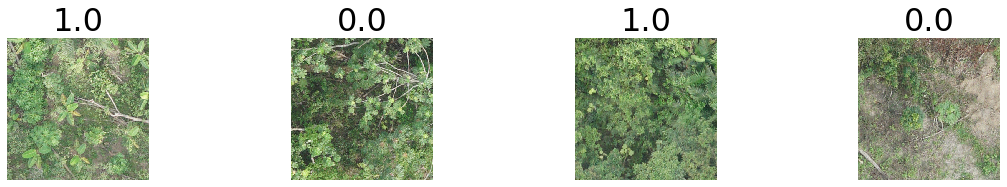

In [8]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(50, 12), rows=4, cols= 10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims * 255).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0, 2, 3, 1))
    f = plt.figure(figsize=figsize)
    # cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=32)
        plt.imshow(ims[i], interpolation=None if interp else 'none')


imgs, labels = next(train_it)
plots(imgs, titles=labels)

In [42]:
imgs[1].shape

(160, 320, 3)

In [9]:
# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_file_path,
    verbose=1,
    save_weights_only=True,
    save_freq='epoch')

In [60]:
c_model = load_model(os.path.join(
    saved_model_path, 'classification_model_2023-03-03 18-34-26.428376.h5'))


In [56]:
input_size = (image_height, image_width, 3)
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,
            input_tensor=Input(shape=input_size))
# freeze all VGG layers so they will *not* be updated during the
# training process
# vgg.trainable=False
# flatten the max-pooling output of VGG
flatten=vgg.output
flatten=Flatten()(flatten)
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead=Dense(128, activation="relu")(flatten)
bboxHead=Dense(64, activation="relu")(bboxHead)
bboxHead=Dense(32, activation="relu")(bboxHead)
bboxHead = Dropout(0.5)(bboxHead)
bboxHead = Dense(1, activation="sigmoid")(bboxHead)
model=Model(inputs=vgg.input, outputs=bboxHead)
            # compiling the sequential model
model.compile(loss='binary_crossentropy', metrics=['accuracy'],
                          optimizer='adam')
model.summary()


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0   

In [55]:
w = model.get_weights()

In [57]:
model.set_weights(w)

In [27]:
model.set_weights(c_model.get_weights())

In [ ]:
# fit model
model.fit(train_it, epochs=100, batch_size=64,
          validation_data=val_it, callbacks=[cp_callback])

In [20]:
history = model.fit_generator(
    train_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    epochs=1,
    validation_data=val_it,
    validation_steps=val_it.samples/val_it.batch_size,
    verbose=1, callbacks=[cp_callback]) 


/Users/ernestopoku-kwarteng/Documents/Pycharm Projects/Anaconda/Machine-Learning/ml-env/lib/python3.8/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


630/630 [==============================] - 2095s 3s/step - loss: 0.7321 - accuracy: 0.6910 - val_loss: 0.6400 - val_accuracy: 0.7065

Epoch 00001: saving model to data/classification/training/train_ckpt/cp.ckpt


In [59]:
model.fit(train_it, validation_data=val_it, callbacks=[cp_callback], epochs=2)

Epoch 1/2
631/631 [==============================] - 5758s 9s/step - loss: 0.6092 - accuracy: 0.7057 - val_loss: 0.6070 - val_accuracy: 0.7065

Epoch 00001: saving model to data/classification/training/train_ckpt/cp.ckpt
Epoch 2/2
214/631 [=========>....................] - ETA: 1:05:26 - loss: 0.6066 - accuracy: 0.7069

KeyboardInterrupt: 

In [33]:
model.fit(train_it, validation_data=val_it, callbacks=[cp_callback], epochs=2)


Epoch 1/3
631/631 [==============================] - 1911s 3s/step - loss: 0.4980 - accuracy: 0.7783 - val_loss: 0.3574 - val_accuracy: 0.8420

Epoch 00001: saving model to data/classification/training/train_ckpt/cp.ckpt
Epoch 2/3
631/631 [==============================] - 6911s 11s/step - loss: 0.4094 - accuracy: 0.8211 - val_loss: 0.3121 - val_accuracy: 0.8623

Epoch 00002: saving model to data/classification/training/train_ckpt/cp.ckpt
Epoch 3/3
631/631 [==============================] - 2844s 5s/step - loss: 0.3366 - accuracy: 0.8635 - val_loss: 0.2487 - val_accuracy: 0.8781

Epoch 00003: saving model to data/classification/training/train_ckpt/cp.ckpt


In [62]:
c_model.evaluate(val_it)

111/111 [==============================] - 366s 3s/step - loss: 0.2487 - accuracy: 0.8781


[0.24867448210716248, 0.8781038522720337]

In [15]:
model.evaluate(train_it)

314/631 [=============>................] - ETA: 13:18 - loss: 0.3223 - accuracy: 0.8623

KeyboardInterrupt: 

In [61]:
#Model is saved as h5 format after training.
from datetime import datetime
iu.create_dir_if_not_exists(saved_model_path)
model.save(os.path.join(saved_model_path, 'classification_model_' + str(datetime.now()).replace(':', '-') + '.h5'))


In [16]:
#Load from checkpoint
# Loads the weights
model.load_weights(checkpoint_file_path)

In [14]:
# Evaluate the model
loss, acc = model.evaluate(val_it, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

125/125 - 1320s - loss: 5.4416 - accuracy: 0.1760
Untrained model, accuracy: 17.60%


In [17]:
# Re-evaluate the model
loss, acc = model.evaluate(val_it, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

125/125 - 1331s - loss: 0.1521 - accuracy: 0.9578
Restored model, accuracy: 95.78%


In [68]:
test_imgs, test_labels = next(test_it)
predictions = model.predict(test_imgs)

In [35]:
def split_image(image, row_count, col_count):
    parts = []
    width, height = image.size
    left = 0
    top = 0
    right = width / col_count
    bottom = height / row_count
    for r in range(row_count):
        top = int(r * (height / row_count))
        bottom = int(top + (height / row_count))
        for c in range(col_count):
            left = int(c * (width / col_count))
            right = int(left + (width / col_count))
            part = image.crop((left, top, right, bottom))
            parts.append(part)
    return parts

In [51]:
def predict_saved_image(model, im, image_size):
    height,width = image_size
    #divide image
    # parts = split_image(im, 2, 2)
    mining_site_detected = False
    resized_image = im.resize((width, height))
    np_image = np.asarray(resized_image) / 255
    pred = model.predict(np.array(np_image).reshape(1, height, width, 3))
    return pred[0][0]
    # return pred[0][0] > 0.4, pred[0][0]
    # print(pred[0][0])
    # iu.display_image(im)           


In [52]:
pred_path = 'data/classification/training/val/plantain/e2aaf51e-6af8-4b16-934a-dd404fdc591e.png'
image = iu.read_image(pred_path, 'RGB')
print(predict_saved_image(model,image, image_size))


0.012664199


In [66]:
#Test images are predicted and saved to the predictions directory.
folder_path = 'data/classification/predictions-plantain'
# folder_path = 'data/classification/predictions'
image_paths = iu.get_all_files(
    folder_path, '*.png',False)
iu.create_dir_if_not_exists(prediction_path)
count = 0
for path in image_paths:
    im = iu.read_image(os.path.join(folder_path, path),'RGB')
    score = predict_saved_image(c_model, im, image_size)
    if score > 0.7:
       im.save(os.path.join(prediction_path, path))
    count += 1
    iu.print_progress(count, len(image_paths))
    


Progress: [##################################################] 100.0%

In [67]:
#Test images are predicted and saved to the predictions directory.
folder_path = 'data/plantains'
# folder_path = 'data/classification/predictions'
image_paths = iu.get_all_files(
    folder_path, '*.png', False)
iu.create_dir_if_not_exists('data/plantains-jpg')
count = 0
for path in image_paths:
    im = iu.read_image(os.path.join(folder_path, path), 'RGB')
    im.save(os.path.join('data/plantains-jpg', path.replace('.png', '.jpg')))
    count += 1
    iu.print_progress(count, len(image_paths))


Progress: [##################################################] 100.0%

ValueError: num must be 1 <= num <= 40, not 41

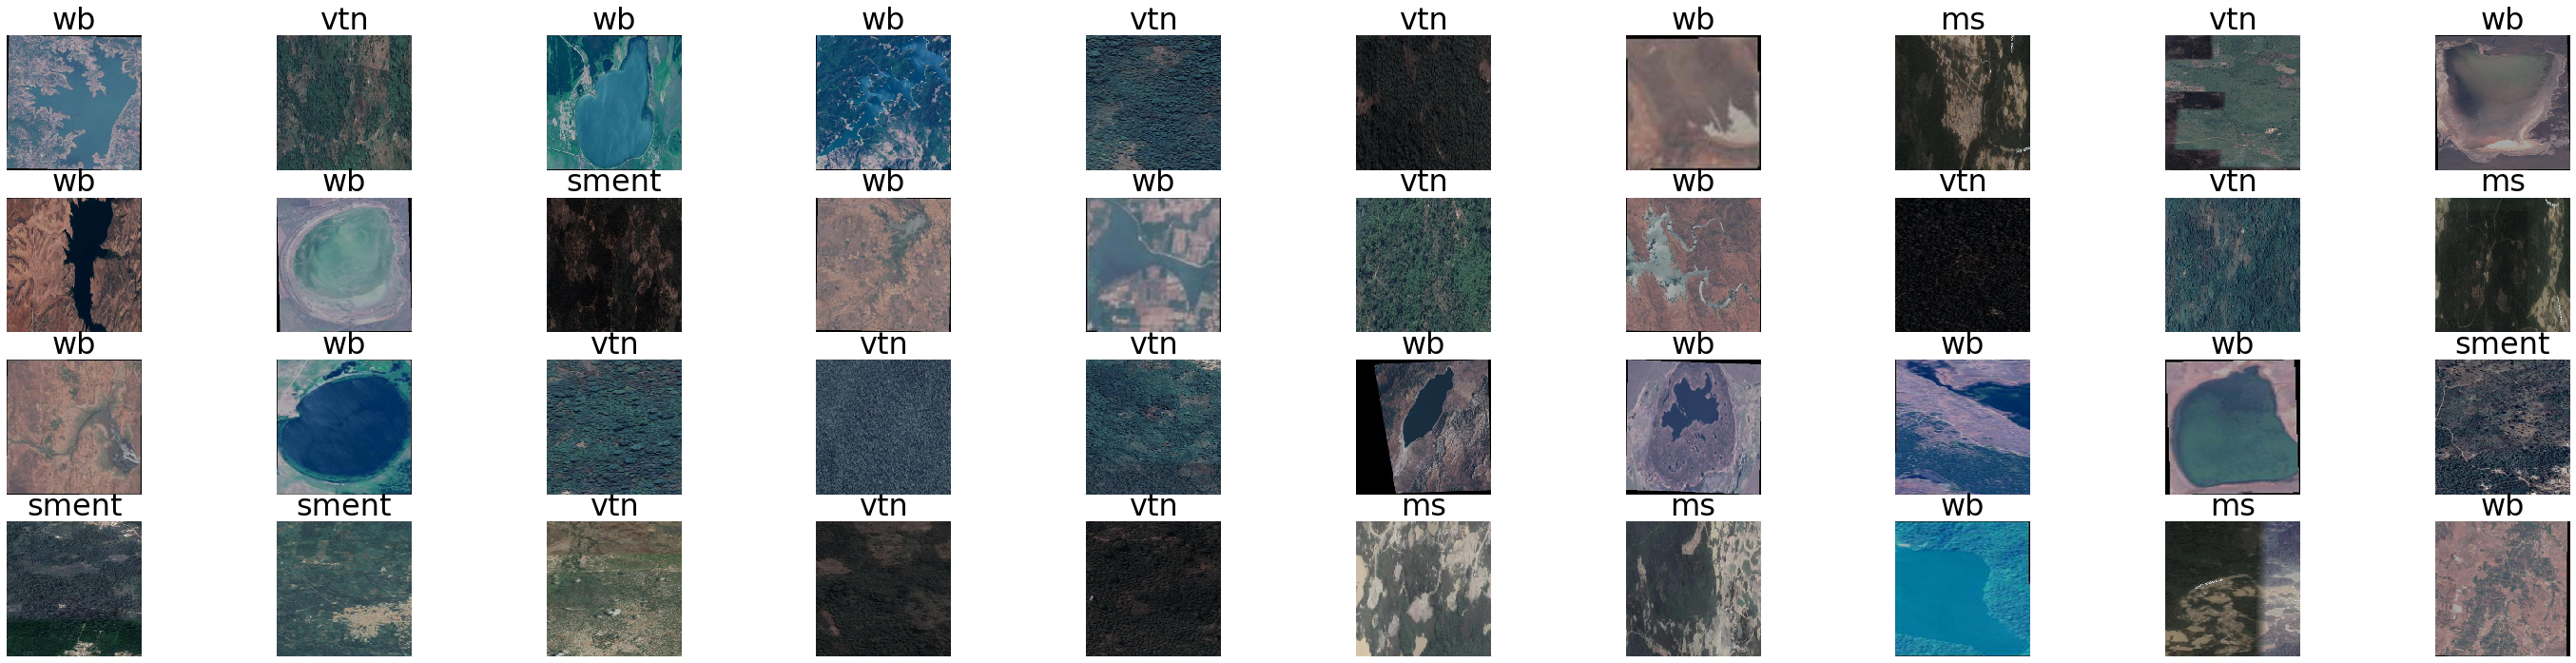

In [76]:
def to_label(value):
    if value == 0:
        return 'ms'
    elif value == 1:
        return 'sment'
    elif value == 2:
        return 'vtn'
    elif value == 3:
        return 'wb'


# test_imgs, test_labels = next(test_it)
# predictions = model.predict(test_imgs)

df = pd.DataFrame()
df['actual'] = test_labels[:, 1]
df['predicted'] = categories
df['predicted_labels'] = df['predicted'].map(lambda x: to_label(x))
plots(test_imgs, titles=df['predicted_labels'])
